In [1]:
import os
os.environ['J_NOTEBOOK'] = '1'

from preprocess.preprocess import *
import PARAMETERS
import sys
sys.path.append('./preprocess/')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from confusion_matrix_pretty_print import print_confusion_matrix
from pathlib import Path

%matplotlib inline


PARAMETERS.PREPROCESS_OPTIMIZATION = True

PARAMETERS.LBP_METHOD = 'riu'
PARAMETERS.METHOD = 'get_pyramid_dataset'
PARAMETERS.INTERPOLATION_ALGORITHM = 'lanczos'
PARAMETERS.BALANCE = False
PARAMETERS.N_SCALES = 5
PARAMETERS.GRAY_INTENSITY = True
PARAMETERS.X2SCALE = True
PARAMETERS.FILE_EXTENSION = PARAMETERS.update_file_extension(PARAMETERS)
PARAMETERS.PLOT = False
PARAMETERS.DATASET = 'CHASE'
TRAIN_SIZE = 14 if PARAMETERS.DATASET != 'CHASE' else 20
TOTAL_SIZE = 20 if PARAMETERS.DATASET != 'CHASE' else 28

pd.DataFrame({k: getattr(PARAMETERS, k) for k in VALID_PARAMETERS.keys()}, index=['Parameters']).head()

,LBP_METHOD,METHOD,INTERPOLATION_ALGORITHM,BALANCE,N_SCALES,GRAY_INTENSITY,X2SCALE
Parameters,riu,get_pyramid_dataset,lanczos,False,5,True,True


In [2]:
# Get CV folds

import pandas as pd
import numpy as np

preprocess = Preprocess(
    lbp_radius=1,
    lbp_method=PARAMETERS.LBP_METHOD,
    height={'DRIVE': 608, 'CHASE': 960, 'STARE': 608}[PARAMETERS.DATASET],
    width={'DRIVE': 576, 'CHASE': 1024, 'STARE': 704}[PARAMETERS.DATASET],
    balance=PARAMETERS.BALANCE
)
masks_path = f'../dataset/{PARAMETERS.DATASET}/training/mask/'
masks = sorted(os.listdir(masks_path))[:TRAIN_SIZE]

n_pixels = {}
for i, mask_path in enumerate(masks):
    mask = preprocess.read_img(masks_path + mask_path)
    n_pixels[i] = np.sum(mask > 100)
    
pixel_ref = {}

for k, v in n_pixels.items():
    upper = np.sum(np.array(list(n_pixels.values()))[:k+1])
    pixel_ref[k] = (upper - n_pixels[k], upper)

print(pixel_ref)
cv_folds = {}

for i, j in enumerate(range(0, TRAIN_SIZE, round(TRAIN_SIZE/5))):
    cv_folds[i] = (pixel_ref[j][0], pixel_ref[min(j+round(TRAIN_SIZE/5)-1, TRAIN_SIZE-1)][1])
    
print(cv_folds)

{0: (0, 665511), 1: (665511, 1329561), 2: (1329561, 1995828), 3: (1995828, 2659379), 4: (2659379, 3325157), 5: (3325157, 3989789), 6: (3989789, 4653729), 7: (4653729, 5320212), 8: (5320212, 5987174), 9: (5987174, 6653978), 10: (6653978, 7317789), 11: (7317789, 7982284), 12: (7982284, 8648921), 13: (8648921, 9316367), 14: (9316367, 9943283), 15: (9943283, 10571009), 16: (10571009, 11236733), 17: (11236733, 11902121), 18: (11902121, 12566902), 19: (12566902, 13230622)}
{0: (0, 2659379), 1: (2659379, 5320212), 2: (5320212, 7982284), 3: (7982284, 10571009), 4: (10571009, 13230622)}


In [3]:
import pandas as pd

df_train = pd.DataFrame()
df_test = pd.DataFrame()

#for conf in ['_blue', '_blue_lbp_gb', '_green', '_green_lbp_gb']:
for conf in ['_green_lbp_g']:

    df_train_riu = pd.read_pickle(f'../DB/{PARAMETERS.DATASET}/extra_features/preprocess_optimization{conf}/train_train_riu_get_pyramid_dataset_lanczos_balance-False_scales-5_x2-True_gray-intensity-True.pkl', compression='gzip')
    df_test_riu = pd.read_pickle(f'../DB/{PARAMETERS.DATASET}/extra_features/preprocess_optimization{conf}/train_test_riu_get_pyramid_dataset_lanczos_balance-False_scales-5_x2-True_gray-intensity-True.pkl', compression='gzip')

    df_train_riu.columns = [c + '_riu' if c not in ['Original', 'label'] else c for c in df_train_riu.columns]
    df_test_riu.columns = [c + '_riu' if c not in ['Original', 'label'] else c for c in df_test_riu.columns]

    if df_train.shape[0] == 0:
        y_train = df_train_riu['label']
        y_test = df_test_riu['label']
    df_train_riu = df_train_riu.drop(['label'], axis=1)
    df_test_riu = df_test_riu.drop(['label'], axis=1)


    df_train_var = pd.read_pickle(f'../DB/{PARAMETERS.DATASET}/extra_features/preprocess_optimization{conf}/train_train_var_get_pyramid_dataset_lanczos_balance-False_scales-5_x2-True_gray-intensity-True.pkl', compression='gzip')
    df_test_var = pd.read_pickle(f'../DB/{PARAMETERS.DATASET}/extra_features/preprocess_optimization{conf}/train_test_var_get_pyramid_dataset_lanczos_balance-False_scales-5_x2-True_gray-intensity-True.pkl', compression='gzip')

    df_train_var.columns = [c + '_var' if c not in ['Original', 'label'] else c for c in df_train_var.columns]
    df_test_var.columns = [c + '_var' if c not in ['Original', 'label'] else c for c in df_test_var.columns]

    df_train_var = df_train_var.drop(['Original', 'label'], axis=1)
    df_test_var = df_test_var.drop(['Original', 'label'], axis=1)

    df_train_temp = pd.concat([df_train_riu, df_train_var], axis=1)
    df_test_temp = pd.concat([df_test_riu, df_test_var], axis=1)
    df_train_temp.columns = [c + conf for c in df_train_temp.columns]
    df_test_temp.columns = [c + conf for c in df_test_temp.columns]

    if df_train.shape[0] > 0:
        df_train_temp.index = df_train.index
        df_test_temp.index = df_test.index
    df_train = pd.concat([df_train, df_train_temp], axis=1)
    df_test = pd.concat([df_test, df_test_temp], axis=1)
    
display(df_train)
display(df_test)

,Original_green_lbp_g,1:1_riu_green_lbp_g,1:2_riu_green_lbp_g,1:4_riu_green_lbp_g,1:8_riu_green_lbp_g,2:1_1_riu_green_lbp_g,2:1_2_riu_green_lbp_g,2:1_3_riu_green_lbp_g,2:1_4_riu_green_lbp_g,1:1_var_green_lbp_g,1:2_var_green_lbp_g,1:4_var_green_lbp_g,1:8_var_green_lbp_g,2:1_1_var_green_lbp_g,2:1_2_var_green_lbp_g,2:1_3_var_green_lbp_g,2:1_4_var_green_lbp_g
0,3.0,34.0,27.0,8.0,8.0,1.0,15.0,27.0,8.0,3.976974,30.814519,153.386455,191.064222,0.468831,0.833493,1.462552,1.291215
1,3.0,34.0,27.0,8.0,8.0,16.0,8.0,4.0,4.0,9.832586,30.814519,153.386455,191.064222,2.035855,2.604634,0.995104,1.375813
2,3.0,27.0,18.0,8.0,8.0,8.0,27.0,16.0,16.0,20.123559,102.905870,153.386455,191.064222,1.758052,1.868230,3.318338,7.665070
3,3.0,27.0,18.0,8.0,8.0,27.0,35.0,16.0,8.0,45.716180,102.905870,153.386455,191.064222,3.132752,4.647082,18.724626,33.174864
4,3.0,34.0,27.0,8.0,4.0,27.0,35.0,8.0,16.0,98.663678,349.072413,104.079242,151.435393,6.223294,5.210311,45.089799,46.020769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663715,3.0,16.0,1.0,8.0,35.0,34.0,35.0,34.0,35.0,0.500002,1.199575,235.079974,230.610858,0.839314,0.635726,0.766087,0.635726
663716,3.0,16.0,1.0,8.0,35.0,35.0,35.0,35.0,35.0,0.500002,1.199575,235.079974,230.610858,0.635726,0.635726,0.635726,0.635726
663717,3.0,16.0,5.0,8.0,35.0,35.0,35.0,35.0,35.0,0.500002,3.809951,235.079974,230.610858,0.635726,0.635726,0.635726,0.635726
663718,3.0,4.0,5.0,8.0,35.0,35.0,34.0,35.0,27.0,0.658934,3.809951,235.079974,230.610858,0.635726,0.738515,0.635726,0.810166


,Original_green_lbp_g,1:1_riu_green_lbp_g,1:2_riu_green_lbp_g,1:4_riu_green_lbp_g,1:8_riu_green_lbp_g,2:1_1_riu_green_lbp_g,2:1_2_riu_green_lbp_g,2:1_3_riu_green_lbp_g,2:1_4_riu_green_lbp_g,1:1_var_green_lbp_g,1:2_var_green_lbp_g,1:4_var_green_lbp_g,1:8_var_green_lbp_g,2:1_1_var_green_lbp_g,2:1_2_var_green_lbp_g,2:1_3_var_green_lbp_g,2:1_4_var_green_lbp_g
0,3.0,16.0,16.0,8.0,8.0,34.0,34.0,16.0,16.0,16.988454,58.494396,29.566315,43.048993,1.322731,1.249550,16.464544,11.720345
1,3.0,16.0,8.0,8.0,8.0,35.0,34.0,4.0,16.0,20.819956,66.640236,34.361710,56.021326,2.409436,2.423149,10.735880,10.634090
2,3.0,16.0,8.0,8.0,8.0,35.0,35.0,16.0,16.0,23.268062,66.640236,34.361710,56.021326,2.215392,2.671580,12.546933,14.693729
3,3.0,16.0,8.0,8.0,8.0,35.0,35.0,16.0,8.0,24.533626,70.279294,34.361710,56.021326,2.839092,3.205745,15.717141,17.132270
4,3.0,16.0,8.0,8.0,8.0,34.0,35.0,16.0,4.0,27.955704,70.279294,34.361710,56.021326,3.610003,3.456396,16.254065,17.148355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663555,3.0,35.0,35.0,35.0,26.0,9.0,9.0,35.0,35.0,0.158931,4.397001,279.528636,219.149513,0.973273,0.973273,0.635726,0.635726
663556,3.0,35.0,35.0,35.0,26.0,9.0,1.0,35.0,35.0,0.158931,4.397001,279.528636,219.149513,0.973273,0.647410,0.635726,0.499160
663557,3.0,35.0,22.0,8.0,8.0,35.0,35.0,5.0,9.0,0.158931,13.123825,248.629613,194.868526,0.332802,0.135724,0.175937,0.135724
663558,3.0,35.0,22.0,8.0,8.0,35.0,35.0,9.0,9.0,0.158931,13.123825,248.629613,194.868526,0.135724,0.135724,0.135724,0.135724


In [4]:
# CV

from main import init_clf_and_fit
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

def cross_validate_features(features, verbose=True):
    f1_list = []
    acc_list = []
    if isinstance(features['y_train'], pd.Series):
        features['y_train'] = features['y_train'].to_frame()
    for k, v in cv_folds.items():
        df_train_temp = pd.concat(
            [features['x_train'].iloc[cv_folds[0][0]:v[0], :],
             features['x_train'].iloc[v[1]:cv_folds[4][1], :]], axis=0)
        y_train_temp = pd.concat(
            [features['y_train'].iloc[cv_folds[0][0]:v[0], :],
             features['y_train'].iloc[v[1]:cv_folds[4][1], :]], axis=0)
        clf = init_clf_and_fit(df_train_temp, y_train_temp.values.ravel(), lgb='Num')
        y_predicted = clf.predict(features['x_train'].iloc[v[0]:v[1], :])
        acc = accuracy_score(features['y_train'].iloc[v[0]:v[1], :], y_predicted)
        acc_list.append(acc)
        f1 = f1_score(features['y_train'].iloc[v[0]:v[1], :], y_predicted)
        f1_list.append(f1)
        mat = confusion_matrix(features['y_train'].iloc[v[0]:v[1], :], y_predicted).ravel()
        if verbose:
            print('Accuracy score: ' + str(acc) + '\n')
            print('F1 score: ' + str(f1) + '\n')
            print('Confusion matrix:\n')
            print_confusion_matrix(features['y_train'].iloc[v[0]:v[1], :].values.ravel(), y_predicted.ravel())
            print(f'Sensivity: {int(mat[3]) / (int(mat[3]) + int(mat[2]))}')
            print(f'Specificity: {int(mat[0]) / (int(mat[0]) + int(mat[1]))}')
            print('-------------------------------------')

    return {'acc': np.mean(acc_list), 'f1': np.mean(f1_list)}


cross_validate_features({'x_train': df_train, 'y_train':y_train})

Accuracy score: 0.9317577524677754

F1 score: 0.6332096429957315

Confusion matrix:

     t/p    0.0   1.0 
      0.0 2321246 46347 
      1.0 135135 156651 
Sensivity: 0.5368694865415065
Specificity: 0.9804244226097982
-------------------------------------
Accuracy score: 0.9348403300770849

F1 score: 0.6475814533029519

Confusion matrix:

     t/p    0.0   1.0 
      0.0 2328159 36635 
      1.0 136744 159295 
Sensivity: 0.5380878870689335
Specificity: 0.9845081643475077
-------------------------------------
Accuracy score: 0.9347519526143545

F1 score: 0.6533165408896667

Confusion matrix:

     t/p    0.0   1.0 
      0.0 2324715 36378 
      1.0 137317 163662 
Sensivity: 0.5437655118795663
Specificity: 0.9845927288759909
-------------------------------------
Accuracy score: 0.93502438459087

F1 score: 0.6532805639725433

Confusion matrix:

     t/p    0.0   1.0 
      0.0 2262058 56468 
      1.0 111736 158463 
Sensivity: 0.5864677515460827
Specificity: 0.9756448709223015
--------

{'acc': 0.9340064873825465, 'f1': 0.6394116369315712}

In [5]:
import pickle
from os import listdir

PATH = fr'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/{PARAMETERS.DATASET}/training/images'
MASK_PATH = fr'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/{PARAMETERS.DATASET}/training/mask'
LABELS_PATH = fr'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/{PARAMETERS.DATASET}/training/1st_manual'

def load_images():
    paths = [f"{PATH}/{path}" for path in sorted(listdir(PATH))][:TRAIN_SIZE]
    return [np.asarray(Image.open(path).convert('RGB'))[:, :, 1] for path in paths]

def load_masks():
    paths = [f"{MASK_PATH}/{path}" for path in sorted(listdir(MASK_PATH))][:TRAIN_SIZE]
    return [np.asarray(Image.open(path).convert('L')) > 100 for path in paths]

IMAGES = load_images()
MASKS = load_masks()

with open(r'/home/fer/Drive/Estudios/Master-IA/TFM/lbp-pyramid/convolution/outputs/16582101419330423_CHASE/population.pkl', 'rb') as f:
    kernels = pickle.load(f)
    
population, fitness = kernels['population'], kernels['fitness']
individual = population[np.argmax(fitness), :]
n_kernels = 6
k_size = (3, 5, 7)

features = [pd.DataFrame()]*TRAIN_SIZE
count = 0
for j, ks in enumerate(k_size):
    k_len = int(ks**2)
    features = [
        pd.concat([feat_df, pd.DataFrame(np.array(
            [cv2.filter2D(img, -1, individual[(count + i*k_len):(count + (i + 1) * k_len)].reshape((ks, ks)))[mask]
             for i in range(n_kernels // len(k_size))]
        ).T, columns=np.arange(j * (n_kernels // len(k_size)), (j + 1) * (n_kernels // len(k_size))))], axis=1)
        for img, mask, feat_df in zip(IMAGES, MASKS, features)
    ]
    count += k_len * (n_kernels // len(k_size))
    
conv_features = pd.concat(features, ignore_index=True)

conv_features.index = df_train.index

In [6]:
"""
cross_validate_features({
    'x_train': pd.concat([df_train, conv_features], axis=1),
    'y_train': y_train,
})
"""

"\ncross_validate_features({\n    'x_train': pd.concat([df_train, conv_features], axis=1),\n    'y_train': y_train,\n})\n"

In [7]:
def load_images_test():
    paths = [f"{PATH}/{path}" for path in sorted(listdir(PATH))][TRAIN_SIZE:]
    return [np.asarray(Image.open(path).convert('RGB'))[:, :, 1] for path in paths]

def load_masks_test():
    paths = [f"{MASK_PATH}/{path}" for path in sorted(listdir(MASK_PATH))][TRAIN_SIZE:]
    return [np.asarray(Image.open(path).convert('L')) > 100 for path in paths]

IMAGES_test = load_images_test()
MASKS_test = load_masks_test()

features_test = [pd.DataFrame()]*TRAIN_SIZE
count = 0
for j, ks in enumerate(k_size):
    k_len = int(ks**2)
    features_test = [
        pd.concat([feat_df, pd.DataFrame(np.array(
            [cv2.filter2D(img, -1, individual[(count + i*k_len):(count + (i + 1) * k_len)].reshape((ks, ks)))[mask]
             for i in range(n_kernels // len(k_size))]
        ).T, columns=np.arange(j * (n_kernels // len(k_size)), (j + 1) * (n_kernels // len(k_size))))], axis=1)
        for img, mask, feat_df in zip(IMAGES_test, MASKS_test, features_test)
    ]
    count += k_len * (n_kernels // len(k_size))
    
conv_features_test = pd.concat(features_test, ignore_index=True)
conv_features_test.index = df_test.index

xtrain shape (13230622, 23)
Columns: Index([ 'Original_green_lbp_g',   '1:1_riu_green_lbp_g',
         '1:2_riu_green_lbp_g',   '1:4_riu_green_lbp_g',
         '1:8_riu_green_lbp_g', '2:1_1_riu_green_lbp_g',
       '2:1_2_riu_green_lbp_g', '2:1_3_riu_green_lbp_g',
       '2:1_4_riu_green_lbp_g',   '1:1_var_green_lbp_g',
         '1:2_var_green_lbp_g',   '1:4_var_green_lbp_g',
         '1:8_var_green_lbp_g', '2:1_1_var_green_lbp_g',
       '2:1_2_var_green_lbp_g', '2:1_3_var_green_lbp_g',
       '2:1_4_var_green_lbp_g',                       0,
                             1,                       2,
                             3,                       4,
                             5],
      dtype='object')
20
0
Image_01L.jpg
665511


/home/fer/anaconda3/envs/TFM/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


665511
Image_01R.jpg
664050
1329561
Image_02L.jpg
666267
1995828
Image_02R.jpg
663551
2659379
Image_03L.jpg
665778
3325157
Image_03R.jpg
664632
3989789
Image_04L.jpg
663940
4653729
Image_04R.jpg
666483
5320212
Image_05L.jpg
666962
5987174
Image_05R.jpg
666804
6653978
Image_06L.jpg
663811
7317789
Image_06R.jpg
664495
7982284
Image_07L.jpg
666637
8648921
Image_07R.jpg
667446
9316367
Image_08L.jpg
626916
9943283
Image_08R.jpg
627726
10571009
Image_09L.jpg
665724
11236733
Image_09R.jpg
665388
11902121
Image_10L.jpg
664781
12566902
Image_10R.jpg
663720


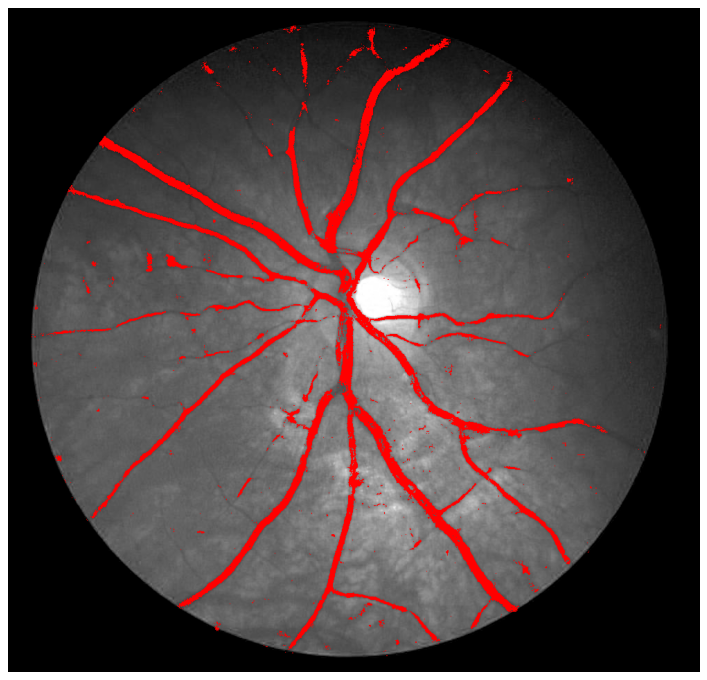

Accuracy score: 0.9495173219678285

F1 score: 0.7063670657700509

Confusion matrix:

     t/p    0.0   1.0 
      0.0 4727942 108159 
      1.0 160383 323004 
Sensivity: 0.6682099435855743
Specificity: 0.9776350824765653


(0.95, 0.706, 4727942, 108159, 160383, 323004)

In [8]:
features = {
    'x_train': pd.concat([df_train, conv_features], axis=1),
    'x_test': pd.concat([df_test, conv_features_test], axis=1),
    'y_train': y_train,
    'y_test': y_test
}

from main import main
PARAMETERS.PLOT = True
PARAMETERS.DATASET = 'CHASE'

print('xtrain shape', features['x_train'].shape)

main(lgb='Num', features=features, plot_once=True, recurrence=True)